<a href="https://colab.research.google.com/github/Pegtom/ViTImageClassificatiton/blob/main/VisionTransformerFinetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# blocks output in Colab 💄
%%capture

! pip install datasets transformers

## Loading Our Custom Dataset

Let us first download the dataset. We need to first upload `kaggle.json` and then:

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

We should then be able to run:

In [ ]:
!kaggle datasets download -d phylake1337/fire-dataset 

 97% 377M/387M [00:11<00:00, 40.8MB/s]
100% 387M/387M [00:11<00:00, 35.9MB/s]


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("imagefolder", data_files="fire-dataset.zip", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-b750f10bf1965d8e/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [ ]:
ds = dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=7)

To make sure that the rest of the code works just like before:

In [ ]:
ex = ds['train'][400]
image = ex['image']
labels = ds['train'].features['label']

## Loading ViT Feature Extractor

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

If we print a feature extractor, we can see its configuration.

In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


In [ ]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.6549, -0.5137, -0.2706,  ..., -0.1843, -0.7725, -0.6471],
          [-0.6784, -0.5765, -0.2863,  ..., -0.2392, -0.5059, -0.7255],
          [-0.7098, -0.6549, -0.3412,  ..., -0.3804, -0.2863, -0.5529],
          ...,
          [-0.5922, -0.4510, -0.5922,  ..., -0.7098, -0.7255, -0.6549],
          [-0.6314, -0.4588, -0.6314,  ..., -0.7490, -0.7412, -0.6627],
          [-0.6863, -0.5608, -0.6863,  ..., -0.7725, -0.7569, -0.6784]],

         [[-0.4980, -0.3569, -0.1137,  ..., -0.0745, -0.6941, -0.5686],
          [-0.5373, -0.4353, -0.1373,  ..., -0.0902, -0.3961, -0.6235],
          [-0.5922, -0.5294, -0.2000,  ..., -0.1922, -0.1451, -0.4196],
          ...,
          [-0.4431, -0.2157, -0.2863,  ..., -0.3804, -0.3882, -0.3333],
          [-0.4745, -0.2235, -0.3333,  ..., -0.4275, -0.4196, -0.3490],
          [-0.5137, -0.3176, -0.3961,  ..., -0.4667, -0.4510, -0.3725]],

         [[-0.8824, -0.7569, -0.5059,  ..., -0.3490, -0.9059, -0.8431],
          [-0

## Processing the Dataset

Now that we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

In [ ]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.7020, -0.6471, -0.7020,  ..., -0.4431, -0.5765, -0.5451],
          [-0.6157, -0.6078, -0.6784,  ..., -0.4667, -0.3569, -0.0039],
          [-0.4275, -0.5373, -0.6157,  ..., -0.6078, -0.3882,  0.1216],
          ...,
          [-0.7647, -0.7098, -0.6941,  ...,  0.0824, -0.0588, -0.0588],
          [-0.7882, -0.7647, -0.7569,  ...,  0.1843,  0.0118,  0.0118],
          [-0.8196, -0.8118, -0.8118,  ...,  0.1451, -0.0196,  0.1216]],

         [[-0.6706, -0.6157, -0.6627,  ..., -0.4588, -0.5922, -0.5608],
          [-0.5843, -0.5765, -0.6392,  ..., -0.4824, -0.3725, -0.0196],
          [-0.3961, -0.5059, -0.5843,  ..., -0.6235, -0.4039,  0.1137],
          ...,
          [-0.7647, -0.7098, -0.7020,  ...,  0.0824, -0.0588, -0.0510],
          [-0.7882, -0.7647, -0.7647,  ...,  0.1843,  0.0118,  0.0196],
          [-0.8196, -0.8118, -0.8118,  ...,  0.1451, -0.0196,  0.1216]],

         [[-0.6784, -0.6235, -0.6706,  ..., -0.4510, -0.5843, -0.5529],
          [-0

While we could call `ds.map` and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, we'll apply a ***transform*** to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [ ]:
# ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert('RGB') for x in example_batch['image']], return_tensors='pt')  # added .convert('RGB')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

We can directly apply this to our dataset using `ds.with_transform(transform)`.

In [ ]:
prepared_ds = ds.with_transform(transform)

Now, whenever we get an example from the dataset, our transform will be 
applied in real time (on both samples and slices, as shown below)

In [ ]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.7020, -0.6471, -0.7020,  ..., -0.4431, -0.5765, -0.5451],
          [-0.6157, -0.6078, -0.6784,  ..., -0.4667, -0.3569, -0.0039],
          [-0.4275, -0.5373, -0.6157,  ..., -0.6078, -0.3882,  0.1216],
          ...,
          [-0.7647, -0.7098, -0.6941,  ...,  0.0824, -0.0588, -0.0588],
          [-0.7882, -0.7647, -0.7569,  ...,  0.1843,  0.0118,  0.0118],
          [-0.8196, -0.8118, -0.8118,  ...,  0.1451, -0.0196,  0.1216]],

         [[-0.6706, -0.6157, -0.6627,  ..., -0.4588, -0.5922, -0.5608],
          [-0.5843, -0.5765, -0.6392,  ..., -0.4824, -0.3725, -0.0196],
          [-0.3961, -0.5059, -0.5843,  ..., -0.6235, -0.4039,  0.1137],
          ...,
          [-0.7647, -0.7098, -0.7020,  ...,  0.0824, -0.0588, -0.0510],
          [-0.7882, -0.7647, -0.7647,  ...,  0.1843,  0.0118,  0.0196],
          [-0.8196, -0.8118, -0.8118,  ...,  0.1451, -0.0196,  0.1216]],

         [[-0.6784, -0.6235, -0.6706,  ..., -0.4510, -0.5843, -0.5529],
          [-0

# Training and Evaluation


### Define our data collator


In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!



In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],  # validation
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 799
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 200


Step,Training Loss,Validation Loss,Accuracy
100,0.007000,0.010846,0.995000
200,0.004500,0.016112,0.995000


***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-100
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-100/config.json
Model weights saved in ./vit-base-beans-demo-v5/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./vit-base-beans-demo-v5/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-200
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-200/config.json
Model weights saved in ./vit-base-beans-demo-v5/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./vit-base-beans-demo-v5/checkpoint-200/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-base-beans-demo-v5/checkpoint-100 (score: 0.010845775716006756).
Saving model checkpoint to ./vit-base-beans-demo-v5

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 230655445GF
  train_loss               =      0.0494
  train_runtime            =  0:03:08.08
  train_samples_per_second =      16.993
  train_steps_per_second   =       1.063


In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])  # validation
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 200
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.995
  eval_loss               =     0.0108
  eval_runtime            = 0:00:09.31
  eval_samples_per_second =     21.472
  eval_steps_per_second   =      2.684


In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'FIRE',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

The resulting model has been shared to [nateraw/vit-base-beans](https://huggingface.co/nateraw/vit-base-beans). I'm assuming you don't have pictures of bean leaves laying around, but if you do, you can try out the model in the browser 🚀.

## Predictions

In [ ]:
subset = 'train'

In [ ]:
outputs = trainer.predict(prepared_ds[subset])
y_pred = outputs.predictions.argmax(1)

***** Running Prediction *****
  Num examples = 799
  Batch size = 8


In [ ]:
prepared_ds[subset].features['label']

ClassLabel(num_classes=2, names=['fire_images', 'non_fire_images'], id=None)

In [ ]:
y_true = [prepared_ds[subset][index]['labels'] for index in range(len(prepared_ds[subset]))]

In [ ]:
filepaths = [ds[subset][index]['image'].filename for index in range(len(prepared_ds[subset]))]

In [ ]:
for true_label, pred_label, filepath in zip(y_true, y_pred, filepaths):
    if true_label != pred_label:
        print('True:', true_label, 'Pred:', pred_label)
        print('Filepath:', filepath, '\n')
        

True: 1 Pred: 0
Filepath: /root/.cache/huggingface/datasets/downloads/extracted/cbd7b736e397bbf8f234ee1a012a6fa56ed809cc19af105e062120645f227a16/fire_dataset/non_fire_images/non_fire.178.png 

True: 1 Pred: 0
Filepath: /root/.cache/huggingface/datasets/downloads/extracted/cbd7b736e397bbf8f234ee1a012a6fa56ed809cc19af105e062120645f227a16/fire_dataset/non_fire_images/non_fire.133.png 



True: 1 Pred: 0
Filepath: /root/.cache/huggingface/datasets/downloads/extracted/cbd7b736e397bbf8f234ee1a012a6fa56ed809cc19af105e062120645f227a16/fire_dataset/non_fire_images/non_fire.178.png 



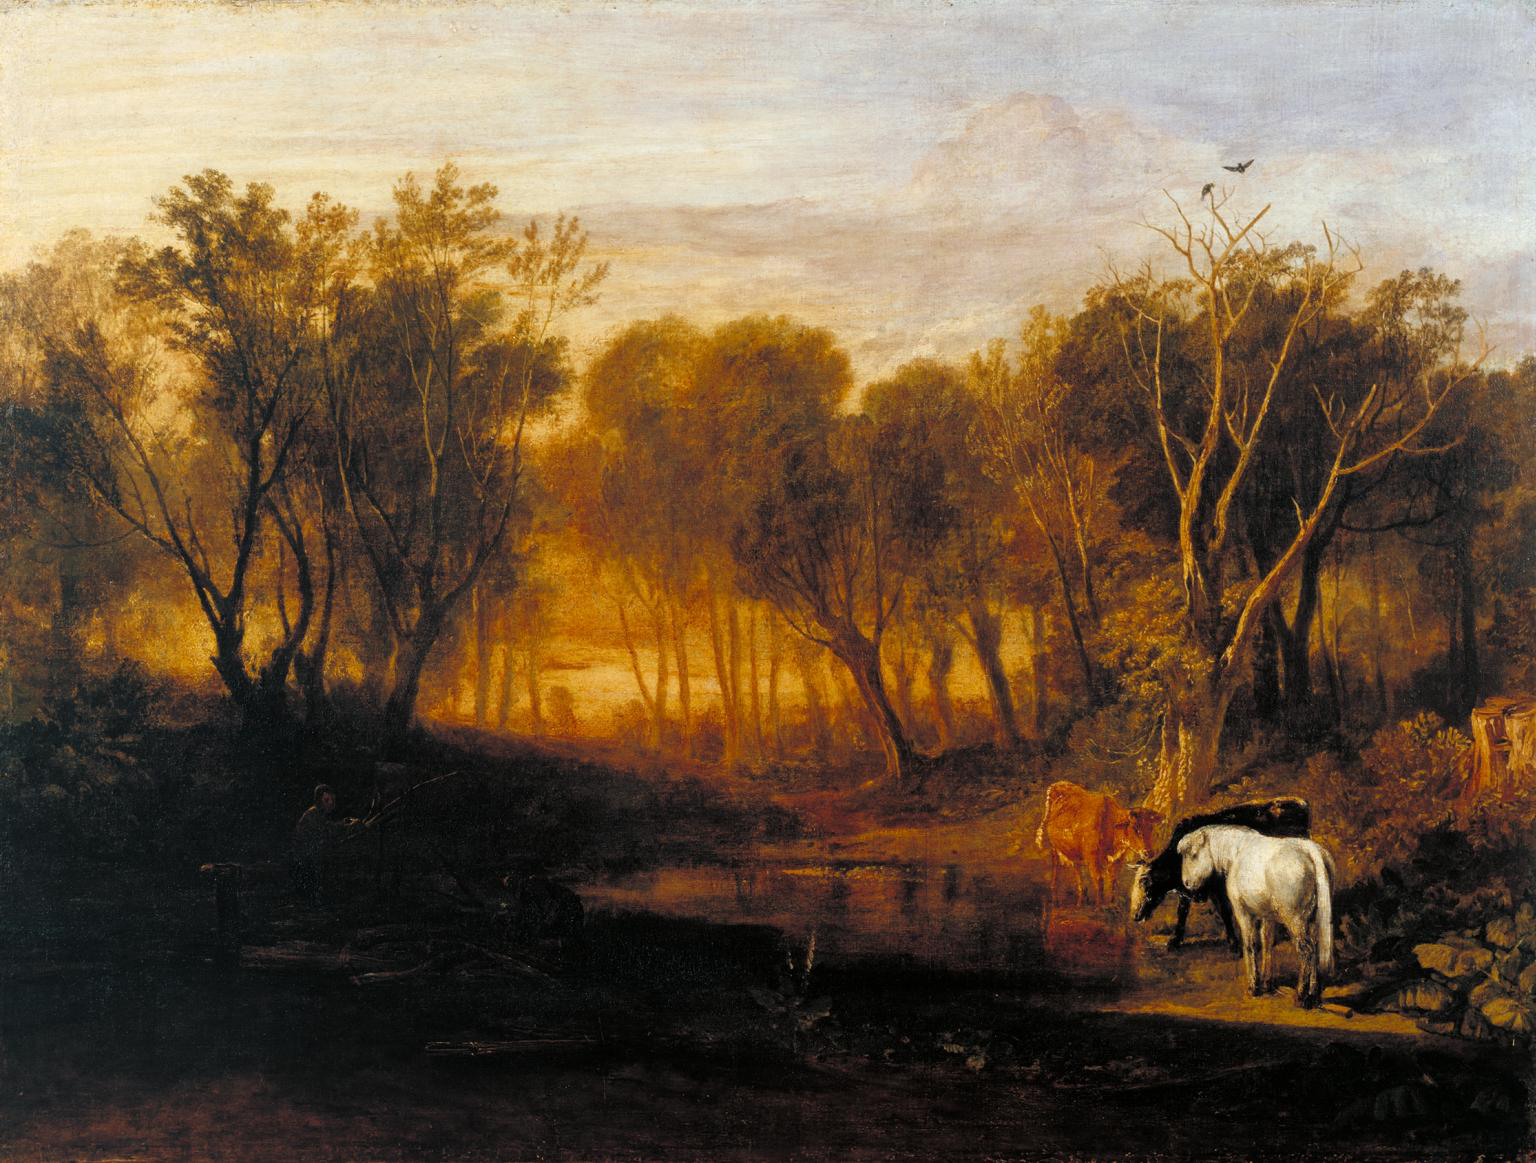

True: 1 Pred: 0
Filepath: /root/.cache/huggingface/datasets/downloads/extracted/cbd7b736e397bbf8f234ee1a012a6fa56ed809cc19af105e062120645f227a16/fire_dataset/non_fire_images/non_fire.133.png 



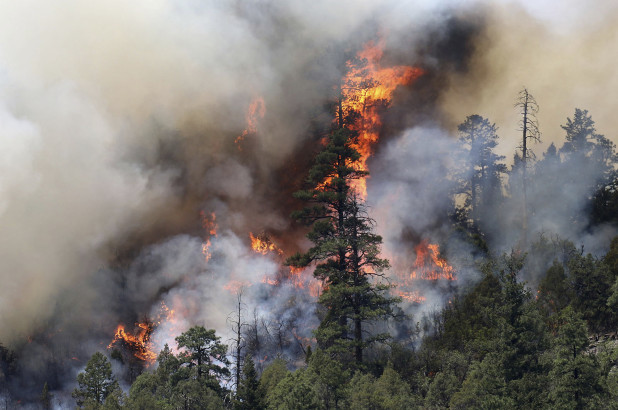

In [ ]:
from PIL import Image

for true_label, pred_label, filepath in zip(y_true, y_pred, filepaths):
    if true_label != pred_label:
        print('True:', true_label, 'Pred:', pred_label)
        print('Filepath:', filepath, '\n')
        img = Image.open(filepath)